In [3]:
import rosbag
import csv
import math

# Specify the bag file and output CSV file
#bag = rosbag.Bag('sytemid3_2025-01-22-18-38-10.bag')


#for chirp signal
bag = rosbag.Bag('system_id_sin_wave_2025-02-21-17-17-37.bag')
output_file = 'systemid.csv'

with open(output_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['time', 'roll_cmd', 'roll_actual', 'pitch_cmd', 'pitch_actual'])  # Column headers

    roll_cmd = None
    pitch_cmd = None

    for topic, msg, t in bag.read_messages(topics=['/mavros/setpoint_raw/attitude', '/mavros/local_position/pose']):
        print(f"Reading topic: {topic} at time: {t.to_sec()}")  # Debug print
        if topic == '/mavros/setpoint_raw/attitude':
            # Extract roll and pitch commands which are from orientation quaternion
            q = msg.orientation
            sin_pitch = 2.0 * (q.w * q.y - q.z * q.x)
            pitch_cmd = math.asin(sin_pitch)
            roll_cmd = math.atan2(2.0 * (q.w * q.x + q.y * q.z), 1.0 - 2.0 * (q.x**2 + q.y**2))

            
            print(f"Commanded roll: {roll_cmd}, Commanded pitch: {pitch_cmd}")  # Debug print
        elif topic == '/mavros/local_position/pose':
            # Extract actual roll and pitch from quaternion orientation
            q = msg.pose.orientation
            sin_pitch = 2.0 * (q.w * q.y - q.z * q.x)
            pitch_actual = math.asin(sin_pitch)
            roll_actual = math.atan2(2.0 * (q.w * q.x + q.y * q.z), 1.0 - 2.0 * (q.x**2 + q.y**2))
            print(f"Actual roll: {roll_actual}, Actual pitch: {pitch_actual}")  # Debug print
            
            # Ensure that individual roll and pitch commands and actual roll and pitch are not None seperately before writing to CSV
            if roll_cmd is not None and roll_actual is not None :
                writer.writerow([t.to_sec(), roll_cmd, roll_actual, pitch_cmd, pitch_actual])
            else:   
                print("Missing data, skipping row")

        



Reading topic: /mavros/setpoint_raw/attitude at time: 35.54
Commanded roll: 0.259691250524091, Commanded pitch: 0.0
Reading topic: /mavros/setpoint_raw/attitude at time: 35.548
Commanded roll: 0.21328681672665642, Commanded pitch: 0.0
Reading topic: /mavros/local_position/pose at time: 35.552
Actual roll: 0.2711580267652777, Actual pitch: 0.0052421003673687174
Reading topic: /mavros/setpoint_raw/attitude at time: 35.558
Commanded roll: 0.16450057019987016, Commanded pitch: 0.0
Reading topic: /mavros/setpoint_raw/attitude at time: 35.569
Commanded roll: 0.11387286765278148, Commanded pitch: 0.0
Reading topic: /mavros/setpoint_raw/attitude at time: 35.578
Commanded roll: 0.06196526982699963, Commanded pitch: 0.0
Reading topic: /mavros/local_position/pose at time: 35.584
Actual roll: 0.3136704370903868, Actual pitch: 0.0047637781085924005
Reading topic: /mavros/setpoint_raw/attitude at time: 35.588
Commanded roll: 0.009354331738586134, Commanded pitch: 0.0
Reading topic: /mavros/setpoint_

This is for roll Dynamics

Estimated Parameters:
k_phi: 12.52373261802912, tau_phi: 2.1623728026582802


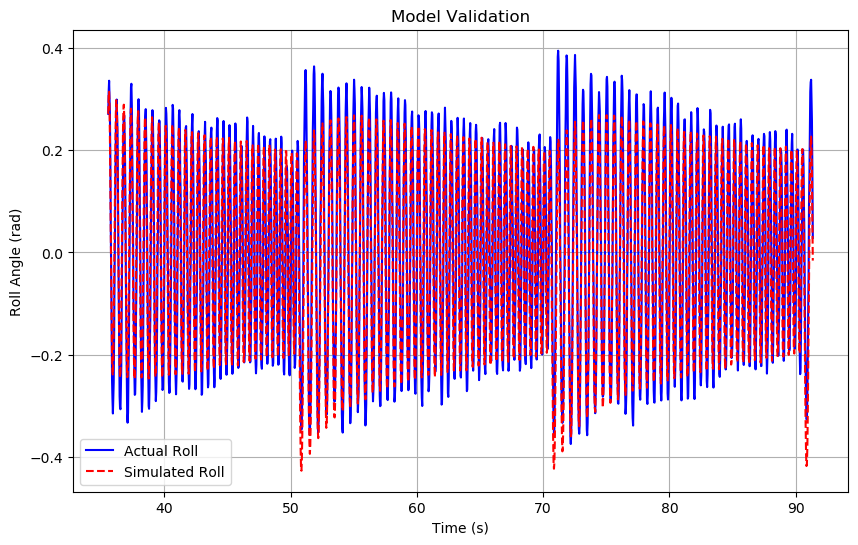

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('systemid.csv')

# Extract relevant columns
time = data['time'].values
roll_cmd = data['roll_cmd'].values
roll_actual = data['roll_actual'].values
pitch_cmd = data['pitch_cmd'].values
pitch_actual = data['pitch_actual'].values

def first_order_model(t, k_phi, tau_phi):
    """First-order system response."""
    phi_predicted = np.zeros_like(t)
    phi_predicted[0] = roll_actual[0]  # Initial condition

    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]
        phi_predicted[i] = phi_predicted[i - 1] + (dt / tau_phi) * (k_phi * roll_cmd[i - 1] - phi_predicted[i - 1])
    
    return phi_predicted

# Perform curve fitting to estimate k_phi and tau_phi
params, _ = curve_fit(first_order_model, time, roll_actual, p0=[1.0, 1.0])

# Extract estimated parameters
k_phi_estimated, tau_phi_estimated = params

print(f"Estimated Parameters:\nk_phi: {k_phi_estimated}, tau_phi: {tau_phi_estimated}")

# Simulate using estimated parameters
phi_simulated = first_order_model(time, k_phi_estimated, tau_phi_estimated)

# Plot results for validation
plt.figure(figsize=(10, 6))
plt.plot(time, roll_actual, label='Actual Roll', color='blue')
plt.plot(time, phi_simulated, label='Simulated Roll', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Roll Angle (rad)')
plt.legend()
plt.title('Model Validation')
plt.grid()
plt.show()






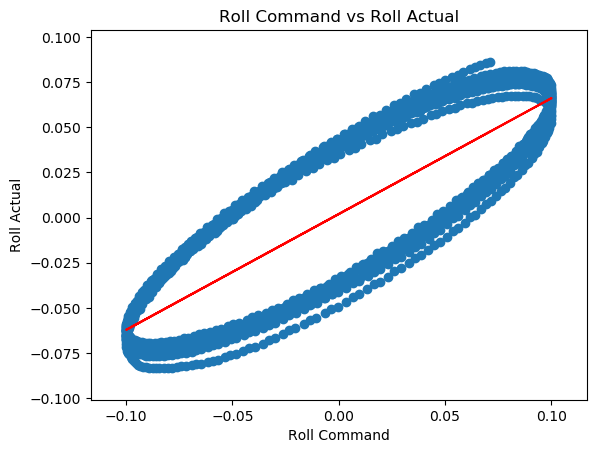

Roll Actual = 0.6418008610462989*Roll Command + 0.0019816060832382664


In [3]:
#fit a linear model to the data roll cmd and roll actual


import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#fit a linear model to the data roll cmd and roll actual
data = np.genfromtxt(output_file, delimiter=',', skip_header=1)
x = data[:,1].reshape(-1,1)
y = data[:,2].reshape(-1,1)
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Roll Command')
plt.ylabel('Roll Actual')
plt.title('Roll Command vs Roll Actual')
plt.show()
#find the equation of the line
m = model.coef_[0][0]
c = model.intercept_[0]
print(f"Roll Actual = {m}*Roll Command + {c}")